In [104]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import BRICS
import plotly.express as px
import plotly.io as pio
import XAIChem

pio.templates.default = "seaborn"

In [78]:
data = pd.read_csv("../../data/ESOL/ESOL.csv")
attributions_functional_groups = pd.read_json("../../data/ESOL/attribution_no_mean.json")
attributions_brics = pd.read_json("../../data/ESOL/attribution_brics_no_mean.json")

# Check prediction error

In [79]:
rmse_df = attributions_functional_groups.\
    drop_duplicates("molecule_smiles").\
    set_index("molecule_smiles")\
    [["non_masked_prediction"]].\
    join(data.set_index("smiles")[["ESOL"]]).\
    apply(lambda row: np.sqrt(1/2 * (row.iloc[0] - row.iloc[1])**2), axis=1).\
    to_frame("RMSE").\
    reset_index()

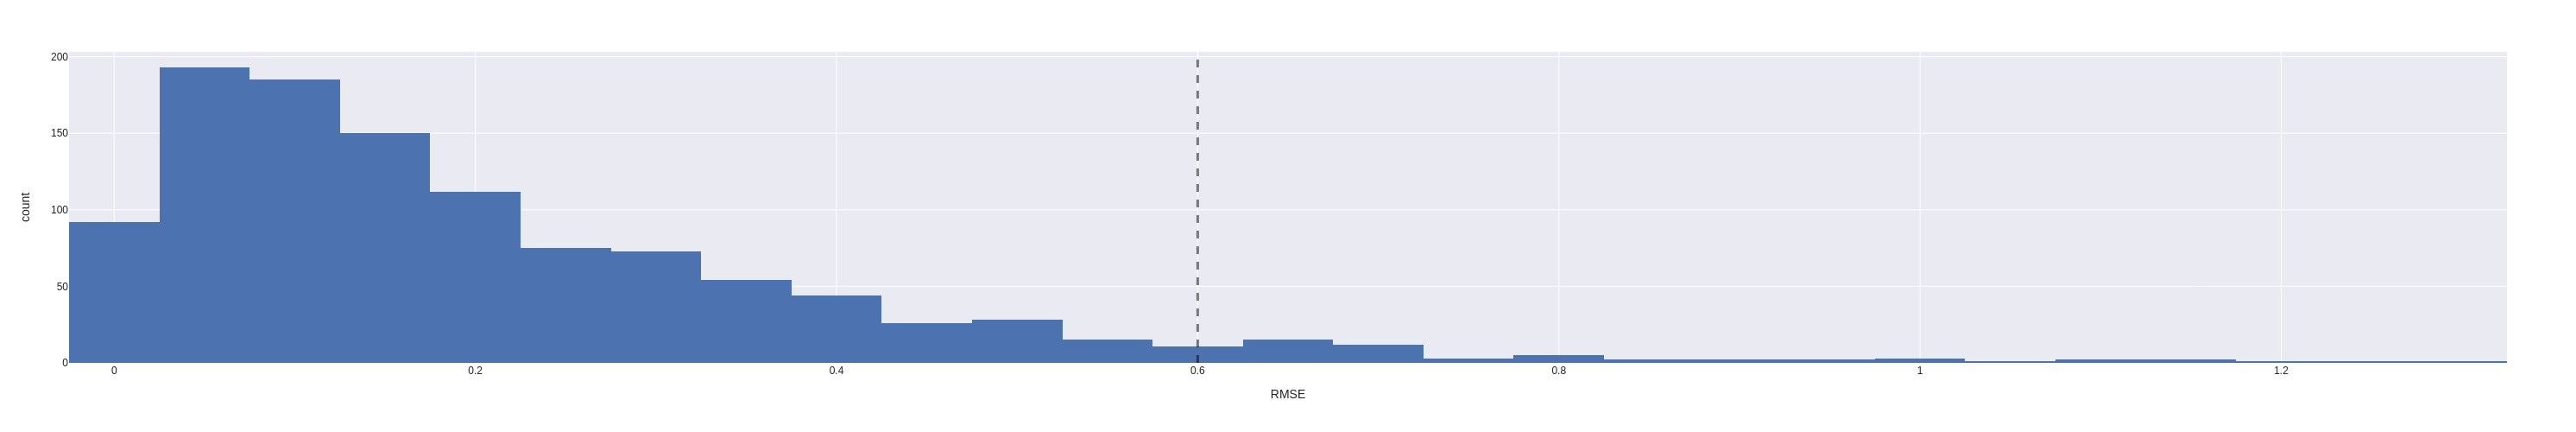

In [80]:
fig = px.histogram(rmse_df, x="RMSE")
fig.add_vline(x=0.6, line_width=3, line_dash="dash")
fig.update_layout(autosize=False, width=800, height=500)
fig.show()

In [42]:
rmse_df.query("RMSE > 0.6").count()

molecule_smiles    54
RMSE               54
dtype: int64

# Attribution ranking 

In [85]:
def rank_compare(df: pd.DataFrame, method1: str, method2: str) -> None:
    
    df[f"{method1}_rank"] = df.groupby("molecule_smiles")[[method1]].rank()
    df[f"{method2}_rank"] = df.groupby("molecule_smiles")[[method2]].rank()

    rank_comparison_df = df.groupby("molecule_smiles").apply(
        lambda molecule: int(all(molecule[f"{method1}_rank"] == molecule[f"{method2}_rank"]))
    ).to_frame("same_rank")

    # Compute fraction of molecules that have the same ranking of their substructures using 
    # the different attribution methods
    fraction_same_rank = rank_comparison_df.same_rank.sum() / len(rank_comparison_df) * 100
    print(f"Fraction of molecules having same attribution ranking: {fraction_same_rank:.2f}")

    display(
        rmse_df.set_index("molecule_smiles")
            .join(rank_comparison_df)
            .groupby("same_rank")
            .mean()
    )


## Functional groups

In [86]:
rank_compare(attributions_functional_groups, "SME", "Shapley_value")

Fraction of molecules having same attribution ranking: 73.15


,RMSE
same_rank,
0,0.232296
1,0.202463


In [87]:
rank_compare(attributions_functional_groups, "Shapley_value", "HN_value")

Fraction of molecules having same attribution ranking: 89.28


,RMSE
same_rank,
0,0.228589
1,0.208297


In [88]:
rank_compare(attributions_functional_groups, "SME", "HN_value")

Fraction of molecules having same attribution ranking: 74.59


,RMSE
same_rank,
0,0.232019
1,0.203134


## BRICS

In [89]:
rank_compare(attributions_brics, "SME", "Shapley_value")

Fraction of molecules having same attribution ranking: 84.50


,RMSE
same_rank,
0,0.239482
1,0.205153


In [90]:
rank_compare(attributions_brics, "Shapley_value", "HN_value")

Fraction of molecules having same attribution ranking: 89.46


,RMSE
same_rank,
0,0.274760
1,0.202898


In [91]:
rank_compare(attributions_brics, "SME", "HN_value")

Fraction of molecules having same attribution ranking: 82.52


,RMSE
same_rank,
0,0.244197
1,0.203330


In [248]:
brics_substructures_df = attributions_brics.groupby("substruct_smiles").apply(
    lambda group: group[["SME", "Shapley_value", "HN_value"]] if len(group) > 5 else None
).reset_index().drop("level_1", axis=1)

In [251]:
brics_substructures_df.groupby("substruct_smiles").std().transpose().style.background_gradient()

substruct_smiles,=C(C)C,=CC,C,C(=O)C,C(=O)C=,C(=O)CC,C(=O)CO,C(=O)S,C(C)(C)C,C(C)=O,C(C)C,C(F)(F)F,C(N)=O,C1C(=O)NC(=O)NC1=O,C1OCC(O)C(O)C1O,C=O,CC,CC#N,CC(C)C,CC=C,CC=O,CCC,CCCC,CCO,CO,N,N(C)C,N1C(=O)NCC1=O,NC,O,OC,OC=O,OP(=S)(O)O,OP(=S)(OC)OC,S,SC,c1cc(Cl)ccc1Cl,c1ccc(Cl)c(Cl)c1,c1ccc(Cl)cc1,c1ccc(Cl)cc1Cl,c1ccc(O)cc1,c1cccc(Cl)c1,c1cccc(Cl)c1Cl,c1ccccc1,c1ccccc1Cl,c1ncnc(Cl)n1,c1ncncn1
SME,0.633952,0.410233,0.083347,0.210711,0.215175,0.238225,0.381312,0.124082,0.552100,0.308302,0.401341,0.262240,0.359657,0.582362,0.232991,0.209268,0.212850,0.349760,0.598267,0.235527,0.212333,0.539420,0.592584,0.360603,0.525966,0.139242,0.216125,0.201691,0.209224,0.217437,0.155729,0.199718,0.207637,0.377884,0.131261,0.242300,0.610758,0.906544,0.579720,0.619379,0.497440,0.534104,0.459872,0.620355,0.379591,0.323986,0.607602
Shapley_value,0.317289,0.236327,0.091689,0.140417,0.092002,0.209930,0.217073,0.072127,0.276249,0.236231,0.280581,0.159229,0.202455,0.276569,0.186946,0.115663,0.173621,0.266340,0.399472,0.077557,0.121758,0.378548,0.330836,0.262583,0.345937,0.093508,0.142930,0.127340,0.219145,0.140849,0.127747,0.115470,0.133144,0.147041,0.083656,0.144780,0.305698,0.431751,0.231387,0.289221,0.287676,0.258441,0.230869,0.398630,0.159400,0.232943,0.230955
HN_value,0.168238,0.417394,0.354980,0.370467,0.258898,0.286495,0.259009,0.093191,0.239173,0.220783,0.260398,0.125071,0.184742,0.234607,0.300555,0.287269,0.160982,0.117523,0.346560,0.070685,0.180642,0.332944,0.282524,0.143555,0.257306,0.279941,0.145564,0.161269,0.252057,0.290068,0.138820,0.115470,0.097499,0.054541,0.232574,0.130290,0.305698,0.407962,0.178234,0.328304,0.273866,0.261033,0.230869,0.377016,0.131705,0.213209,0.201592
